In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def TDT(n1,n2,n3,n4,n5,n6):
    b = n1+n3+2*n4; c = n2+n3+2*n5
    if b +c == 0:
        return 0
    else:
        return (b-c)**2/(b+c)

In [3]:
def LS(p,q,r,s,t,u): #local sensitivity
    stat = TDT(p,q,r,s,t,u); v = np.zeros(0)
    M = TDT(p,q,r,s,t,u); m = TDT(p,q,r,s,t,u)
    if p >= 1:
        v = [TDT(p-1,q+1,r,s,t,u), TDT(p-1,q,r+1,s,t,u), TDT(p-1,q,r,s+1,t,u), 
             TDT(p-1,q,r,s,t+1,u), TDT(p-1,q,r,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if q >= 1:
        v = [TDT(p+1,q-1,r,s,t,u), TDT(p,q-1,r+1,s,t,u), TDT(p,q-1,r,s+1,t,u), 
             TDT(p,q-1,r,s,t+1,u), TDT(p,q-1,r,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if r >= 1:
        v = [TDT(p+1,q,r-1,s,t,u), TDT(p,q+1,r-1,s,t,u), TDT(p,q,r-1,s+1,t,u), 
             TDT(p,q,r-1,s,t+1,u), TDT(p,q,r-1,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if s >= 1:
        v = [TDT(p+1,q,r,s-1,t,u), TDT(p,q+1,r,s-1,t,u), TDT(p,q,r+1,s-1,t,u), 
             TDT(p,q,r,s-1,t+1,u), TDT(p,q,r,s-1,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if t >= 1:
        v = [TDT(p+1,q,r,s,t-1,u), TDT(p,q+1,r,s,t-1,u), TDT(p,q,r+1,s,t-1,u), 
             TDT(p,q,r,s+1,t-1,u), TDT(p,q,r,s,t-1,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if u >= 1:
        v = [TDT(p+1,q,r,s,t,u-1), TDT(p,q+1,r,s,t,u-1), TDT(p,q,r+1,s,t,u-1), 
             TDT(p,q,r,s+1,t,u-1), TDT(p,q,r,s,t+1,u-1)]
        M = max([max(v),M])
        m = min([min(v),m])
    
    return max([M-stat, stat-m])

In [4]:
def SS(table,beta): #smooth sensitivity
    p = table[0]; q = table[1]; r = table[2]; s = table[3]; t = table[4]; u = table[5]
    GS = 8; ls = LS(p,q,r,s,t,u)
    if beta >= math.log(40/13):
        return ls
    else:
        dist = int(math.ceil(math.log(GS/ls))/beta)
        ss = 0
        for yp in range(-dist,dist+1):
            for yq in range(-dist,dist+1):
                for yr in range(-dist,dist+1):
                    for ys in range(-dist,dist+1):
                        for yt in range(-dist,dist+1):
                            yu = -yp-yq-yr-ys-yt
                            if p+yp >= 0 and q+yq >= 0 and r+yr >= 0 and s+ys >= 0 and t+yt >= 0 and u+yu >= 0:
                                dxy = (math.fabs(yp) + math.fabs(yq) + math.fabs(yr) + math.fabs(ys) + math.fabs(yt) + math.fabs(yu))/2
                                if dxy <= dist:
                                    ss = max([LS(p+yp,q+yq,r+yr,s+ys,t+yt,u+yu)*math.exp(-(beta*dxy)), ss])
        return ss

In [5]:
def SS_DPstats(table,epsilon): #use the standard Cauchy distribution
    p = table[0]; q = table[1]; r = table[2]; s = table[3]; t = table[4]; u = table[5]
    f = TDT(p,q,r,s,t,u); beta = epsilon/4
    ss = SS(table,beta)
    d1 = np.random.standard_cauchy(1); d2 = np.random.standard_cauchy(1)
    if math.fabs(d1) <= math.fabs(d2):
        A = f + ((4*ss)/epsilon)*d1
    else:
        A = f + ((4*ss)/epsilon)*d2
    return A

In [6]:
def GS_DPstats(table,epsilon):
    p = table[0]; q = table[1]; r = table[2]; s = table[3]; t = table[4]; u = table[5]
    f = TDT(p,q,r,s,t,u)
    A = f + np.random.laplace(loc = 0.0, scale = 8/epsilon, size=1)
    return A

In [7]:
def generateData(n):
    table = np.zeros(6)
    table[0] = np.random.binomial(n,1/6)
    table[1] = np.random.binomial(n-table[0],1/5)
    table[2] = np.random.binomial(n-table[0]-table[1],1/4)
    table[3] = np.random.binomial(n-table[0]-table[1]-table[2],1/3)
    table[4] = np.random.binomial(n-table[0]-table[1]-table[2]-table[3],1/2)
    table[5] = n-table[0]-table[1]-table[2]-table[3]-table[4]
    return table

In [8]:
def Diff(n,m,epsilon):
    diff = np.zeros((2,m)); stats = np.zeros((m,2))
    ss_stats = np.zeros(m); gs_stats = np.zeros(m)
    
    for i in range(m):
        table = generateData(n)
        p = table[0]; q = table[1]; r = table[2]; s = table[3]; t = table[4]; u = table[5]
        stats[i][0] = TDT(p,q,r,s,t,u)
        stats[i][1] = i
        ss_stats[i] = SS_DPstats(table,epsilon)
        gs_stats[i] = GS_DPstats(table,epsilon)
        
        
    sstats = sorted(stats, key=lambda x:(x[0]),reverse=True)
    s = np.zeros(m); ss = np.zeros(m); gs = np.zeros(m)
    for i in range(m):
        s[i] = sstats[i][0]
        
        ss[i] = ss_stats[int(sstats[i][1])]
        diff[0][i] = math.fabs(s[i]-ss[i])
        
        gs[i] = gs_stats[int(sstats[i][1])]
        diff[1][i] = math.fabs(s[i]-gs[i])
        
    return diff

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


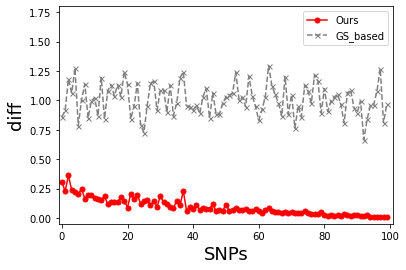

In [9]:
n = 1000; m = 100; epsilon = 8

sum_diff = np.zeros((2,m))

for j in range(50):
    diff = Diff(n,m,epsilon)
    for k in range(m):
        sum_diff[:,k] += diff[:,k]
diff = sum_diff / 50

index = np.zeros(m)
for i in range(m):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 1.80)
plt.xlim(-1, 101)
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "GS_based")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_TDT_N=1000_epsilon=8.png")
fig.savefig("figs/diff_TDT_N=1000_epsilon=8.eps", bbox_inches="tight", pad_inches=0.05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


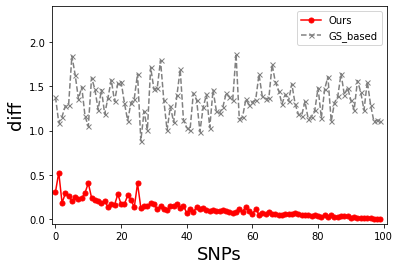

In [10]:
n = 1000; m = 100; epsilon = 6

sum_diff = np.zeros((2,m))

for j in range(50):
    diff = Diff(n,m,epsilon)
    for k in range(m):
        sum_diff[:,k] += diff[:,k]
diff = sum_diff / 50

index = np.zeros(m)
for i in range(m):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 2.40)
plt.xlim(-1, 101)
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "GS_based")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_TDT_N=1000_epsilon=6.png")
fig.savefig("figs/diff_TDT_N=1000_epsilon=6.eps", bbox_inches="tight", pad_inches=0.05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


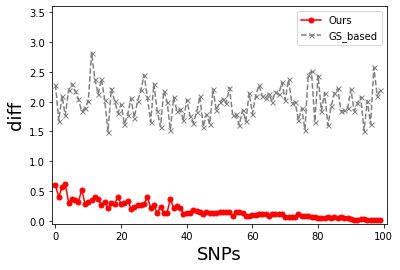

In [11]:
n = 1000; m = 100; epsilon = 4

sum_diff = np.zeros((2,m))

for j in range(50):
    diff = Diff(n,m,epsilon)
    for k in range(m):
        sum_diff[:,k] += diff[:,k]
diff = sum_diff / 50

index = np.zeros(m)
for i in range(m):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 3.60)
plt.xlim(-1, 101)
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "GS_based")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_TDT_N=1000_epsilon=4.png")
fig.savefig("figs/diff_TDT_N=1000_epsilon=4.eps", bbox_inches="tight", pad_inches=0.05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


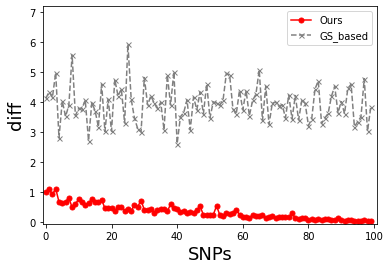

In [12]:
n = 1000; m = 100; epsilon = 2

sum_diff = np.zeros((2,m))

for j in range(50):
    diff = Diff(n,m,epsilon)
    for k in range(m):
        sum_diff[:,k] += diff[:,k]
diff = sum_diff / 50

index = np.zeros(m)
for i in range(m):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 7.20)
plt.xlim(-1, 101)
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "GS_based")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_TDT_N=1000_epsilon=2.png")
fig.savefig("figs/diff_TDT_N=1000_epsilon=2.eps", bbox_inches="tight", pad_inches=0.05)